In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import norm
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] #added from snow class

from mpl_toolkits.axes_grid1 import make_axes_locatable

<xarray.Dataset>
Dimensions:  (time: 51, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>


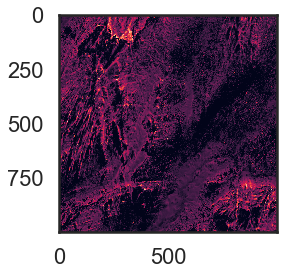

In [2]:
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
# #~~~~ ds peak
# dpeak = ds.isel(time=[0,7,18,30,42,49]) 
# dpeak.close()
# ds = dpeak
# ds.close()
#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
#grab 2015, 2016, 2017 nearest peak SWE
# ds=ds.isel(time=slice(2,5))
# ds.close()
#northern slice of data
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
d.close()
#~~~convert to ints again
d=d.astype(np.int16, copy=False)
print(d)
plt.imshow(d.snow.isel(time=1))

# d.to_netcdf('~/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc')
#dataset is d here! 3km by 3km area in northern Tuolumne (2 valleys west of slide canyon)

### attempt to fully use Xarray.....(right track, needs dimention work)

In [93]:
d

<xarray.Dataset>
Dimensions:  (time: 51, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>

In [74]:
# compute stats from xarray dataset
x_gt0 = d.snow.where(d.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

mu=mu_gt0 #51 means over x,y dimention
sigma=sig_gt0 #51 stds over x,y dimention

<class 'xarray.core.dataarray.DataArray'>


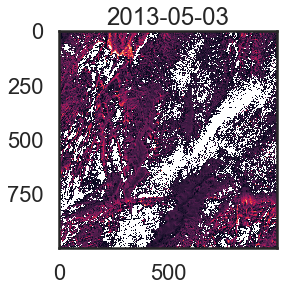

In [46]:
#plot to show you have values >0
which_date=2
plt.imshow(x_gt0.isel(time=which_date))
title=(d['time'].dt.strftime('%Y-%m-%d')[which_date])
plt.title(str(title.values))

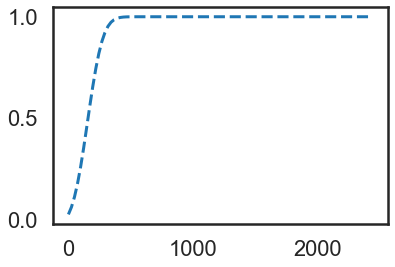

In [112]:
#1) set number of bins to use
n_bins=100

#2) compute histogram and bin edges for each lidar layer (dim=time)
    ######~~NOTE - likely need to compute using a dimention, i.e. result should be multiple hist,bin returns
hist, bins = np.histogram(x_gt0.values[~np.isnan(x_gt0.values)], bins=n_bins, density=True)

#3) compute y
#~~NOTE - only working because it grabs one value from mu and sigma instead of working through a dim
y = norm.pdf(bins, mu.values[0], sigma.values[0]).cumsum()
#get rid of last value of y (bins and y are same size)
y /= y[-1]

#4) plot it 
plt.plot(bins, y, linestyle='--', linewidth=3)

In [110]:
print('hist is length:', len(hist), 'type:', type(hist))
print('bins is length:', len(bins), 'type:', type(bins))
print('mu is length:', len(mu), 'type:', type(mu))
print('sigma is length:', len(sigma), 'type:', type(sigma))

hist is length: 100 type: <class 'numpy.ndarray'>
bins is length: 101 type: <class 'numpy.ndarray'>
mu is length: 51 type: <class 'xarray.core.dataarray.DataArray'>
sigma is length: 51 type: <class 'xarray.core.dataarray.DataArray'>


### try with Will
problem: hist and bins computes over full dataset
y uses bins, mu, and sigma to compute. 
    bins - all data being used
    mu and sigma - one values per lidar flight

In [109]:
#1) set number of bins to use
n_bins=100

#2) compute histogram and bin edges for each lidar layer (dim=time)
#~~NOTE - likely need to compute using a dimention, i.e. result should be multiple hist,bin returns
hist, bins = np.histogram(x_gt0.values[~np.isnan(x_gt0.values)], bins=n_bins, density=True)

#3) compute y
#~~NOTE - only working because it grabs one value from mu and sigma instead of working through a dim
# y = norm.pdf(bins, mu.values[0], sigma.values[0]).cumsum()
y = norm.pdf(bins, mu, sigma).cumsum()
#get rid of last value of y (bins and y are same size)
y /= y[-1]

#4) plot it 
plt.plot(bins, y, linestyle='--', linewidth=3)

ValueError: operands could not be broadcast together with shapes (101,) (51,) 

In [121]:
x_gt0.values

array([[[197., 195., 190., ..., 259., 270., 260.],
        [194., 192., 189., ..., 260., 273., 270.],
        [188., 188., 190., ..., 242., 266., 270.],
        ...,
        [ 52., 117., 212., ..., 150., 157., 186.],
        [101., 217., 252., ..., 270., 253., 267.],
        [131., 214., 249., ..., 341., 320., 303.]],

       [[120., 117., 113., ..., 186., 203., 198.],
        [117., 114., 111., ..., 182., 207., 207.],
        [114., 111., 111., ..., 176., 207., 206.],
        ...,
        [ 96.,  97., 188., ..., 105., 105., 135.],
        [ 40., 132., 213., ..., 229., 214., 219.],
        [ 91., 140., 188., ..., 306., 292., 263.]],

       [[100.,  98.,  92., ..., 152., 173., 172.],
        [ 97.,  93.,  90., ..., 154., 185., 181.],
        [ 92.,  90.,  91., ..., 147., 180., 160.],
        ...,
        [150., 165., 163., ..., 105.,  92., 115.],
        [ 78., 119., 137., ..., 209., 189., 197.],
        [ 70., 114., 141., ..., 279., 259., 233.]],

       ...,

       [[ nan,  nan,  na

### numpy rescue (using code from 50m cdf)

In [86]:
def compute_cdf(depth_array, n_bins):
    
    '''
    Compute Cumulative Density Function (CDF). Solves the cumulative probability of a given x value.
    Determines the probability that a random observation will be less/greater than a certain value.
    
    What is the probability (read y-axis) that you get a snow depth measurement in the Tuolumne Basin
    that is ____ meters deep (x_axis)? 
    
    at the 1, you say: 100% of the time you get a measurement that is (x-axis) meters or less
    at the .5 you say: 50% of the time you get a measurment that is (x-axis) meters or less
    
        args:
            depth_array: ndarray of snow depth values
            n_bins: number of bins
          
            
        returns:
            bins: bin edges (left edges and final right side edge)
            y: cumulative sum of probability density function (PDF). 
            
    '''
    
    d = depth_array[depth_array > 0] #data are inside masked area and >0, scalar
    
    mu = np.nanmean(d)
    sigma = np.nanstd(d)
    
    hist, bins = np.histogram(d, bins=n_bins, density=True)
    
    y = norm.pdf(bins, mu, sigma).cumsum()
    y /= y[-1]
    
    return bins, y

In [91]:
# ~~~ Annual CDF plots
fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

n_bins=100 #number of bins in histogram
years = list(range(2013,2019)) #which years
date_df = d.time.to_dataframe() #store dates in dataframe

fig,axs=plt.subplots(2,3,figsize = (20, 10)) #make one figure, with axs (plot1, plot2, etc.)
flat_ax = axs.flat #flatten the axes (subplots)

for ii, year in enumerate(years):
    print('loop')
    ax = flat_ax[ii] #which plot are you plotting
    

    startTime = pd.to_datetime("10-01-{}".format(year-1))
    endTime = pd.to_datetime("09-30-{}".format(year))

    current_df = date_df.loc[startTime:endTime] #buy pickles!

    for i,row in current_df.iterrows():

        f = row['time']
        print(f)
        
        for layer in d.snow.values:
    print(layer.shape)
    print(type(layer))
#         depth_array = np.loadtxt(f, skiprows=6) * 100 #cm
#         bins,y = compute_cdf(depth_array, n_bins, mask_50m, np.max(mask_50m))

#         ax.plot(bins, y,  linestyle='--', linewidth=3, label=str(i.date())) #color=cycle[i],
#         ax.set_xlim(0,1000)
#         ax.set_title('{}'.format(year), fontsize = fs_titles-3)
#         ax.set_xlabel('Snow Depth (cm)', fontsize = fs_axes-2)
#         ax.set_ylabel('Probability', fontsize = fs_axes-2)
#         ax.legend()

# plt.tight_layout()
# # plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/annual_cdf_subplots.png', dpi=150)
# plt.show()

IndentationError: expected an indented block (<ipython-input-91-2e225838e6ac>, line 31)

In [7]:
for layer in d.snow.values:
    print(layer.shape)
    print(type(layer))

(1000, 1000)
<class 'numpy.ndarray'>
(1000, 1000)
<class 'numpy.ndarray'>
(1000, 1000)
<class 'numpy.ndarray'>
(1000, 1000)
<class 'numpy.ndarray'>
(1000, 1000)
<class 'numpy.ndarray'>
(1000, 1000)
<class 'numpy.ndarray'>


In [31]:
d

<xarray.Dataset>
Dimensions:  (time: 51, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>

In [43]:
for grp in d.groupby('time.year').groups:
    print(grp)


2013
2014
2015
2016
2017
2018


In [47]:
d.groupby('time.year').groups

{2013: [0, 1, 2, 3, 4, 5],
 2014: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 2015: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
 2016: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 2017: [40, 41, 42, 43, 44, 45, 46, 47, 48],
 2018: [49, 50]}